In [38]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
from einops import rearrange
from utils import invnormalize_imagenet

In [4]:
proj_dir = os.path.dirname(os.getcwd())
if proj_dir not in sys.path:
    sys.path.append(proj_dir)

In [5]:
from configs import get_cfg_defaults
from datasets.habitat import HabitatDataset

# Configure and load the dataset

In [74]:
cfg = get_cfg_defaults()
cfg.merge_from_file(os.path.join(proj_dir, 'configs/train_bev_depth.yaml'))

# Override configurations
cfg.train_split_file = os.path.join(proj_dir, 'splits/gibson/gibson_1img.txt')
cfg.val_split_file = os.path.join(proj_dir, 'splits/gibson/gibson_1img.txt')
cfg.data_path = '/scratch/shantanu/HabitatGibson/data'
cfg.bev_dir = '/scratch/shantanu/HabitatGibson/bevs/partial_occupancy'
cfg.batch_size = 1
cfg.width = 480
cfg.height = 480
cfg.focal_length = 320
cfg.hfov = 73.74  # np.rad2deg(np.arctan2(w/2, f)) * 2

cfg.freeze()

In [75]:
load_keys = set()
load_keys.add('bev')
load_keys.add('ego_map_gt')
load_keys.add('depth')
load_keys.add('semantics')

with open(cfg.train_split_file, 'r') as f:
    train_filenames = f.read().splitlines()
with open(cfg.val_split_file, 'r') as f:
    val_filenames = f.read().splitlines()
    
print(train_filenames[:5], val_filenames[:5])

train_dataset = HabitatDataset(cfg, filenames=train_filenames, is_train=True, load_keys=load_keys)
val_dataset = HabitatDataset(cfg, filenames=val_filenames, is_train=False, load_keys=load_keys)

['Lindenwood 2511'] ['Lindenwood 2511']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


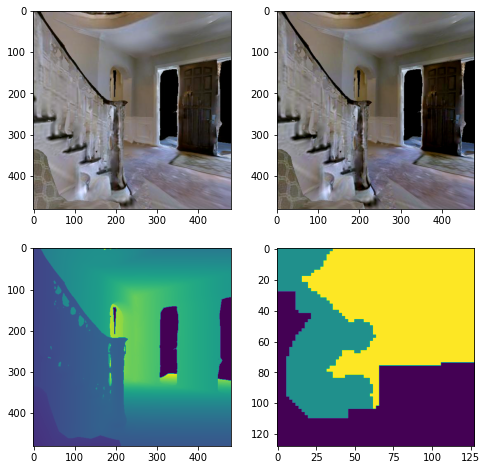

In [76]:
idx = 0
item = train_dataset[0]

rgb = invnormalize_imagenet(item[('color', 'l', 0)].squeeze()).numpy().transpose(1,2,0)
rgb_aug = invnormalize_imagenet(item[('color_aug', 'l', 0)].squeeze()).numpy().transpose(1,2,0)
depth = item[('depth_gt', 'l')].squeeze().numpy()
bev = item[('bev_gt', 'l')].squeeze().numpy()

fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(8, 8))
ax = axes.flatten()
ax[0].imshow(rgb)
ax[1].imshow(rgb_aug)
ax[2].imshow(depth)
ax[3].imshow(bev)

# Creating patches and embedding

(480, 480, 3)


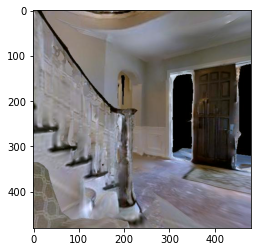

In [103]:
rgb = np.clip(rgb, a_min=0, a_max=1)
plt.imshow(rgb)
print(rgb.shape)

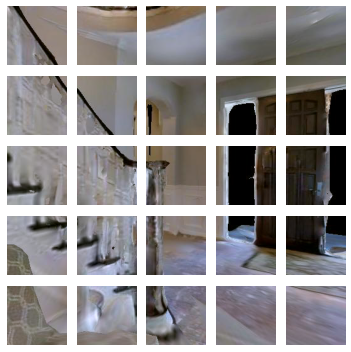

In [113]:
patch_size = 96

x_rgb = rearrange(rgb, "(x p_x) (y p_y) c -> (x y) p_x p_y c", p_x=patch_size, p_y=patch_size)
fig, ax = plt.subplots(ncols=5, nrows=5, figsize=(5, 5))

for i in range(5):
    for j in range(5):
        ax[i, j].imshow(x_rgb[i*5 + j])
        ax[i,j].axis('off')
        ax[i, j].margins(0)
        
plt.tight_layout()

In [116]:
patch_size = 16 # Standard for ViT

rgb = 
x_rgb = rearrange(rgb, "(x p_x) (y p_y) c -> (x y) (p_x p_y c)", p_x=patch_size, p_y=patch_size)


(900, 768)